In [1]:
from PIL import Image, ImageEnhance, ImageFilter
import os

# Load image
input_image_path = r'C:\Users\tusha\OneDrive\Desktop\Training\glioma\gg (1).jpg'
image = Image.open(input_image_path)

# Create output directory
output_dir = 'augmented_images'
os.makedirs(output_dir, exist_ok=True)

# 1. Rotate 45 degrees
rotated = image.rotate(45)
rotated.save(os.path.join(output_dir, 'rotated_45.jpg'))

# 2. Flip horizontally
flipped = image.transpose(Image.FLIP_LEFT_RIGHT)
flipped.save(os.path.join(output_dir, 'flipped_horizontal.jpg'))

# 3. Flip vertically
flipped_v = image.transpose(Image.FLIP_TOP_BOTTOM)
flipped_v.save(os.path.join(output_dir, 'flipped_vertical.jpg'))

# 4. Rotate -30 degrees
rotated_neg = image.rotate(-30)
rotated_neg.save(os.path.join(output_dir, 'rotated_neg_30.jpg'))

print(f'4 augmented images saved to {output_dir}')

4 augmented images saved to augmented_images


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import numpy as np

# --- GLOBAL PARAMETERS ---
DATA_DIR_TRAIN = r'C:/Users/tusha/OneDrive/Desktop/Training'
DATA_DIR_TEST = r'C:/Users/tusha/OneDrive/Desktop/Testing'  # Used for validation and final test
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123
EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_CLASSES_4_CLASS = 4  # Glioma, Meningioma, Pituitary, No Tumor

print("--- Step 1: Loading Data (4-Class Setup) ---")

# Load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR_TRAIN,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Load test/validation data
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR_TEST,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Convert datasets to numpy arrays for model training simplicity
def dataset_to_numpy(ds):
    images = []
    labels = []
    for batch in ds:
        x, y = batch
        images.append(x.numpy())
        labels.append(y.numpy())
    return np.concatenate(images), np.concatenate(labels)

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, NUM_CLASSES_4_CLASS)
y_test_cat = to_categorical(y_test, NUM_CLASSES_4_CLASS)

# --- Define CNN models adapted for 128x128 input and 4 classes ---

def LeNet():
    model = models.Sequential([
        layers.Conv2D(6, kernel_size=5, activation='tanh', input_shape=IMG_SIZE + (3,)),
        layers.AveragePooling2D(pool_size=2),
        layers.Conv2D(16, kernel_size=5, activation='tanh'),
        layers.AveragePooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(NUM_CLASSES_4_CLASS, activation='softmax')
    ])
    return model

def AlexNet():
    model = models.Sequential([
        layers.Conv2D(96, 11, strides=4, activation='relu', input_shape=IMG_SIZE + (3,), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(384, 3, activation='relu', padding='same'),
        layers.Conv2D(384, 3, activation='relu', padding='same'),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES_4_CLASS, activation='softmax')
    ])
    return model

def ZFNet():
    model = models.Sequential([
        layers.Conv2D(96, 7, strides=2, activation='relu', input_shape=IMG_SIZE + (3,), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(384, 3, activation='relu', padding='same'),
        layers.Conv2D(384, 3, activation='relu', padding='same'),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES_4_CLASS, activation='softmax')
    ])
    return model

def VGGNet():
    model = models.Sequential()
    model.add(layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=IMG_SIZE + (3,)))
    model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(256, 3, activation='relu', padding='same'))
    model.add(layers.Conv2D(256, 3, activation='relu', padding='same'))
    model.add(layers.Conv2D(256, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES_4_CLASS, activation='softmax'))
    return model

def inception_module(x, filters):
    f1, f3r, f3, f5r, f5, proj = filters

    path1 = layers.Conv2D(f1, 1, activation='relu', padding='same')(x)

    path2 = layers.Conv2D(f3r, 1, activation='relu', padding='same')(x)
    path2 = layers.Conv2D(f3, 3, activation='relu', padding='same')(path2)

    path3 = layers.Conv2D(f5r, 1, activation='relu', padding='same')(x)
    path3 = layers.Conv2D(f5, 5, activation='relu', padding='same')(path3)

    path4 = layers.MaxPooling2D(3, strides=1, padding='same')(x)
    path4 = layers.Conv2D(proj, 1, activation='relu', padding='same')(path4)

    return layers.concatenate([path1, path2, path3, path4], axis=-1)

def GoogLeNet():
    input_layer = layers.Input(shape=IMG_SIZE + (3,))
    x = layers.Conv2D(64, 7, strides=2, activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    output_layer = layers.Dense(NUM_CLASSES_4_CLASS, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

def ResNet50():
    model = tf.keras.applications.ResNet50(
        weights=None, include_top=True, input_shape=IMG_SIZE + (3,), classes=NUM_CLASSES_4_CLASS)
    return model

# Dictionary of models
model_dict = {
    'LeNet': LeNet,
    'AlexNet': AlexNet,
    'ZFNet': ZFNet,
    'VGGNet': VGGNet,
    'GoogLeNet': GoogLeNet,
    'ResNet50': ResNet50
}

results = {}

for name, model_fn in model_dict.items():
    print(f"\nTraining {name}...")
    model = model_fn()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"{name} Test Accuracy: {test_acc:.4f}")
    results[name] = test_acc

print("\n=== Summary of Test Accuracies ===")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

--- Step 1: Loading Data (4-Class Setup) ---
Found 8582 files belonging to 4 classes.
Found 1705 files belonging to 4 classes.

Training LeNet...
Epoch 1/30
269/269 - 6s - 20ms/step - accuracy: 0.6898 - loss: 0.7982
Epoch 2/30
269/269 - 5s - 17ms/step - accuracy: 0.7939 - loss: 0.5374
Epoch 3/30
269/269 - 5s - 17ms/step - accuracy: 0.8329 - loss: 0.4400
Epoch 4/30
269/269 - 5s - 17ms/step - accuracy: 0.8630 - loss: 0.3631
Epoch 5/30
269/269 - 5s - 17ms/step - accuracy: 0.8858 - loss: 0.3096
Epoch 6/30
269/269 - 5s - 17ms/step - accuracy: 0.9069 - loss: 0.2633
Epoch 7/30
269/269 - 4s - 17ms/step - accuracy: 0.9227 - loss: 0.2268
Epoch 8/30
269/269 - 5s - 17ms/step - accuracy: 0.9343 - loss: 0.1934
Epoch 9/30
269/269 - 5s - 17ms/step - accuracy: 0.9441 - loss: 0.1688
Epoch 10/30
269/269 - 5s - 17ms/step - accuracy: 0.9578 - loss: 0.1373
Epoch 11/30
269/269 - 5s - 17ms/step - accuracy: 0.9668 - loss: 0.1118
Epoch 12/30
269/269 - 5s - 17ms/step - accuracy: 0.9740 - loss: 0.0934
Epoch 13/30

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

for name, model_fn in model_dict.items():
    print(f"\nTraining {name}...")
    model = model_fn()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"{name} Test Accuracy: {test_acc:.4f}")
    results[name] = test_acc

    # Get predicted class probabilities and labels
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Classification report
    print(f"{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(NUM_CLASSES_4_CLASS)]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"{name} Confusion Matrix:\n{cm}")

    # ROC Curve (One-vs-Rest for multiclass)
    plt.figure(figsize=(8, 6))
    for i in range(NUM_CLASSES_4_CLASS):
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()


NameError: name 'model_dict' is not defined

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

# --- Setup ---
DATA_DIR_TRAIN = r'C:/Users/tusha/OneDrive/Desktop/Training'
DATA_DIR_TEST = r'C:/Users/tusha/OneDrive/Desktop/Testing'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123
EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_CLASSES_4_CLASS = 4

# Load datasets using keras utility
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR_TRAIN,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR_TEST,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Convert to numpy arrays for ease of use
def dataset_to_numpy(ds):
    images = []
    labels = []
    for batch in ds:
        x, y = batch
        images.append(x.numpy())
        labels.append(y.numpy())
    return np.concatenate(images), np.concatenate(labels)

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CLASSES_4_CLASS)
y_test_cat = to_categorical(y_test, NUM_CLASSES_4_CLASS)

# Define your custom VGGNet model for 128x128 input
def VGGNet():
    model = models.Sequential()
    model.add(layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=IMG_SIZE + (3,)))
    model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(256, 3, activation='relu', padding='same'))
    model.add(layers.Conv2D(256, 3, activation='relu', padding='same'))
    model.add(layers.Conv2D(256, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES_4_CLASS, activation='softmax'))
    return model

# Transfer Learning with pretrained VGG16 (ImageNet weights)
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)

# Freeze all layers of the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add new classification head
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(NUM_CLASSES_4_CLASS, activation='softmax')(x)

transfer_model = models.Model(inputs=base_model.input, outputs=output)

# Compile transfer learning model
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print("Training Transfer Learning Model...")
transfer_model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
test_loss_tl, test_acc_tl = transfer_model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Transfer Learning Model Test Accuracy: {test_acc_tl:.4f}")

# Train custom VGGNet model from scratch
custom_model = VGGNet()
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

print("Training Custom Model...")
custom_model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
test_loss_c, test_acc_c = custom_model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Custom Model Test Accuracy: {test_acc_c:.4f}")


Found 8582 files belonging to 4 classes.
Found 1705 files belonging to 4 classes.
Training Transfer Learning Model...
Epoch 1/30
269/269 - 171s - 637ms/step - accuracy: 0.7689 - loss: 0.5984
Epoch 2/30
269/269 - 172s - 638ms/step - accuracy: 0.8651 - loss: 0.3685
Epoch 3/30
269/269 - 172s - 638ms/step - accuracy: 0.8919 - loss: 0.2985
Epoch 4/30
269/269 - 171s - 637ms/step - accuracy: 0.9077 - loss: 0.2597
Epoch 5/30
269/269 - 172s - 638ms/step - accuracy: 0.9218 - loss: 0.2198
Epoch 6/30
269/269 - 171s - 636ms/step - accuracy: 0.9282 - loss: 0.2035
Epoch 7/30
269/269 - 172s - 639ms/step - accuracy: 0.9401 - loss: 0.1732
Epoch 8/30
269/269 - 174s - 646ms/step - accuracy: 0.9462 - loss: 0.1591
Epoch 9/30
269/269 - 174s - 647ms/step - accuracy: 0.9515 - loss: 0.1465
Epoch 10/30
269/269 - 175s - 652ms/step - accuracy: 0.9567 - loss: 0.1303
Epoch 11/30
269/269 - 175s - 650ms/step - accuracy: 0.9601 - loss: 0.1176
Epoch 12/30
269/269 - 180s - 669ms/step - accuracy: 0.9661 - loss: 0.1108
Epo

C:\Users\tusha\anaconda3\envs\tf311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
269/269 - 494s - 2s/step - accuracy: 0.7046 - loss: 0.6818
Epoch 2/30
269/269 - 502s - 2s/step - accuracy: 0.8751 - loss: 0.3221
Epoch 3/30
269/269 - 497s - 2s/step - accuracy: 0.9240 - loss: 0.1916
Epoch 4/30
269/269 - 507s - 2s/step - accuracy: 0.9708 - loss: 0.0806
Epoch 5/30
269/269 - 422s - 2s/step - accuracy: 0.9816 - loss: 0.0593
Epoch 6/30
269/269 - 418s - 2s/step - accuracy: 0.9897 - loss: 0.0292
Epoch 7/30
269/269 - 417s - 2s/step - accuracy: 0.9915 - loss: 0.0229
Epoch 8/30
269/269 - 420s - 2s/step - accuracy: 0.9929 - loss: 0.0221
Epoch 9/30
269/269 - 419s - 2s/step - accuracy: 0.9918 - loss: 0.0227
Epoch 10/30
269/269 - 433s - 2s/step - accuracy: 0.9974 - loss: 0.0109
Epoch 11/30
269/269 - 438s - 2s/step - accuracy: 0.9937 - loss: 0.0213
Epoch 12/30
269/269 - 437s - 2s/step - accuracy: 0.9988 - loss: 0.0046
Epoch 13/30
269/269 - 437s - 2s/step - accuracy: 1.0000 - loss: 7.6001e-05
Epoch 14/30
269/269 - 437s - 2s/step - accuracy: 1.0000 - loss: 3.1477e-05
Epoch 1

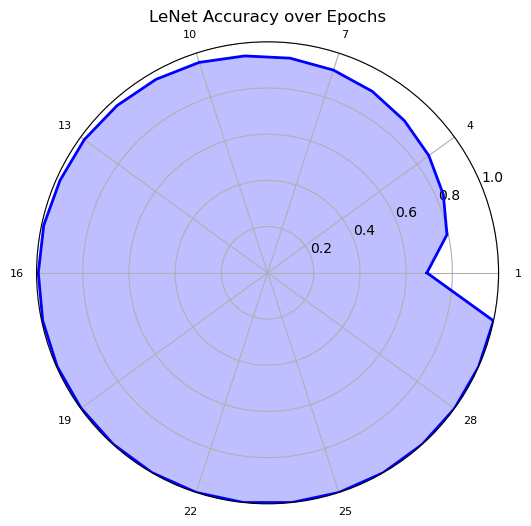

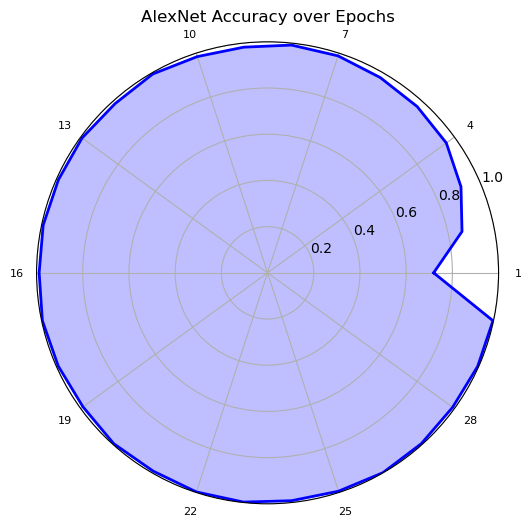

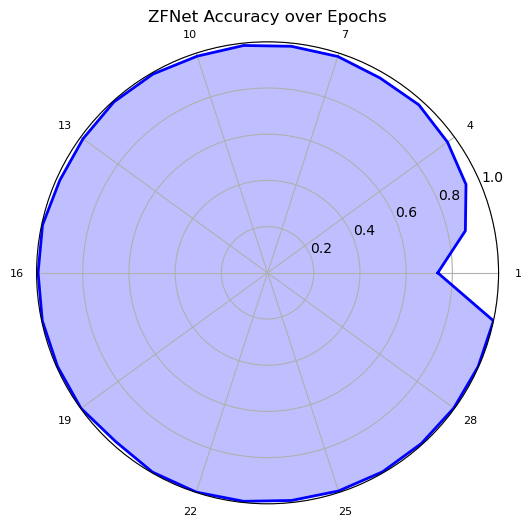

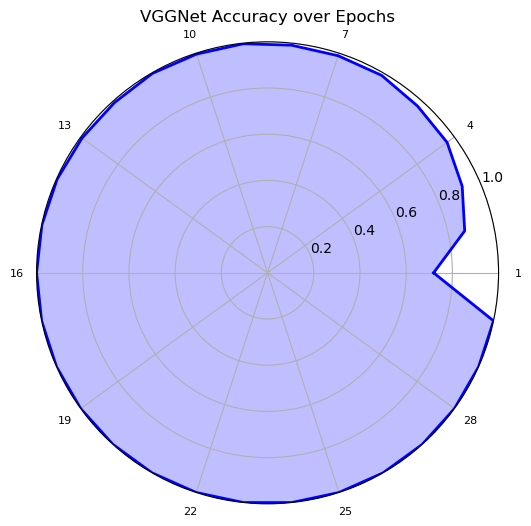

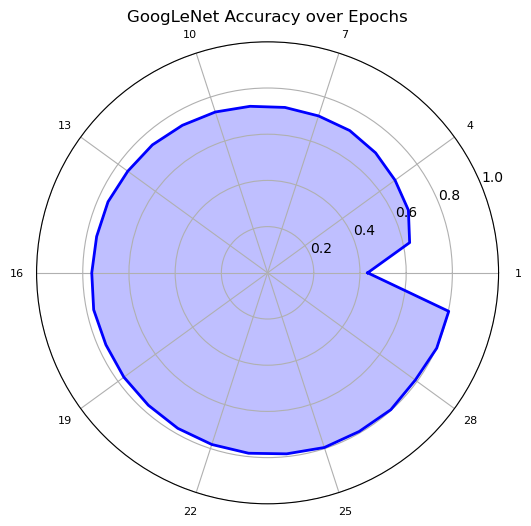

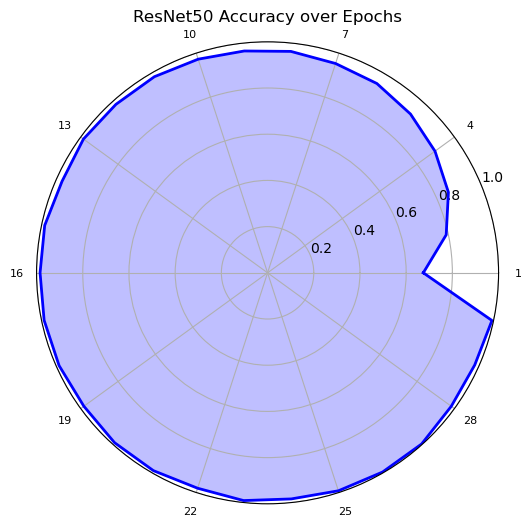

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Epochs
epochs = np.arange(1, 31)

# Example accuracy values per epoch for each model (replace these with your actual values)
accuracies = {
    'LeNet': [0.6898, 0.7939, 0.8329, 0.8630, 0.8858, 0.9069, 0.9227, 0.9343, 0.9441, 0.9578, 0.9668, 0.9740, 0.9808, 0.9837, 0.9906, 0.9924, 0.9953, 0.9971, 0.9978, 0.9987, 0.9994, 0.9997, 0.9998, 0.9999, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0],
    'AlexNet': [0.7189, 0.8606, 0.9165, 0.9564, 0.9682, 0.9759, 0.9875, 0.9913, 0.9822, 0.9842, 0.9938, 0.9860, 0.9927, 0.9910, 0.9931, 0.9889, 0.9966, 0.9920, 0.9875, 0.9953, 0.9911, 0.9974, 0.9980, 0.9920, 0.9941, 0.9990, 0.9950, 0.9903, 0.9955, 0.9976],
    'ZFNet': [0.7368, 0.8754, 0.9403, 0.9627, 0.9786, 0.9738, 0.9846, 0.9860, 0.9896, 0.9861, 0.9932, 0.9948, 0.9874, 0.9846, 0.9960, 0.9934, 0.9971, 0.9955, 0.9983, 0.9830, 0.9963, 0.9983, 0.9946, 0.9910, 0.9931, 0.9949, 0.9946, 0.9964, 0.9980, 1.0],
    'VGGNet': [0.7188, 0.8724, 0.9222, 0.9606, 0.9709, 0.9871, 0.9882, 0.9908, 0.9972, 0.9955, 0.9969, 0.9911, 0.9927, 0.9970, 0.9988, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'GoogLeNet': [0.4333, 0.6288, 0.6673, 0.6821, 0.6988, 0.7111, 0.7141, 0.7199, 0.7248, 0.7320, 0.7374, 0.7452, 0.7482, 0.7560, 0.7565, 0.7611, 0.7696, 0.7661, 0.7688, 0.7714, 0.7774, 0.7814, 0.7854, 0.7880, 0.7952, 0.7932, 0.7974, 0.7903, 0.8016, 0.8018],
    'ResNet50': [0.6742, 0.7905, 0.8570, 0.8959, 0.9248, 0.9463, 0.9527, 0.9638, 0.9656, 0.9724, 0.9802, 0.9812, 0.9852, 0.9739, 0.9864, 0.9849, 0.9889, 0.9879, 0.9829, 0.9897, 0.9888, 0.9805, 0.9914, 0.9842, 0.9922, 0.9958, 0.9969, 0.9830, 0.9816, 0.9931]
}

# Plot a radar chart for each model
for model_name, acc in accuracies.items():
    # Setup radar chart values
    angles = np.linspace(0, 2 * np.pi, len(acc), endpoint=False).tolist()
    acc += acc[:1]  # repeat first value to close radar shape
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, acc, color="blue", linewidth=2)
    ax.fill(angles, acc, color="blue", alpha=0.25)

    ax.set_title(f'{model_name} Accuracy over Epochs')
    ax.set_ylim(0, 1)

    # Set ticks for epochs (show limited for clarity)
    ax.set_xticks(angles[:-1][::3])
    ax.set_xticklabels([str(i) for i in range(1, 31)][::3], fontsize=8)

    plt.show()


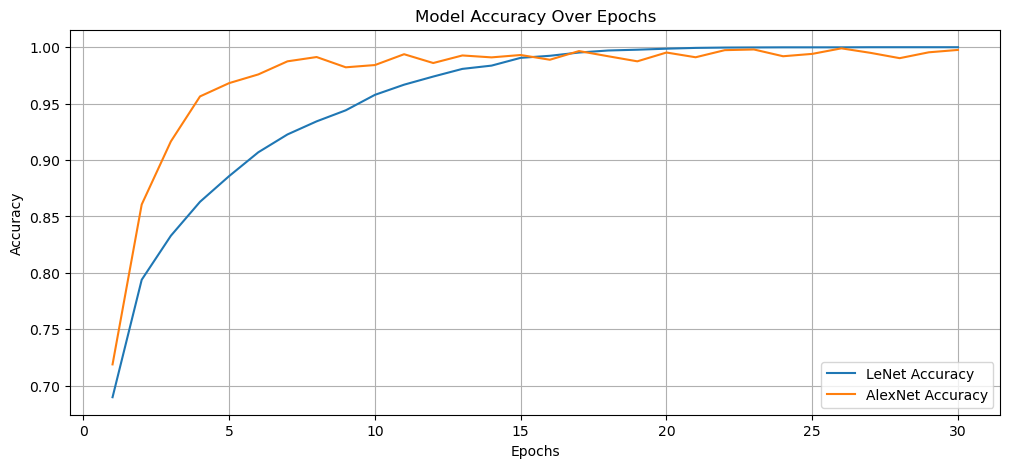

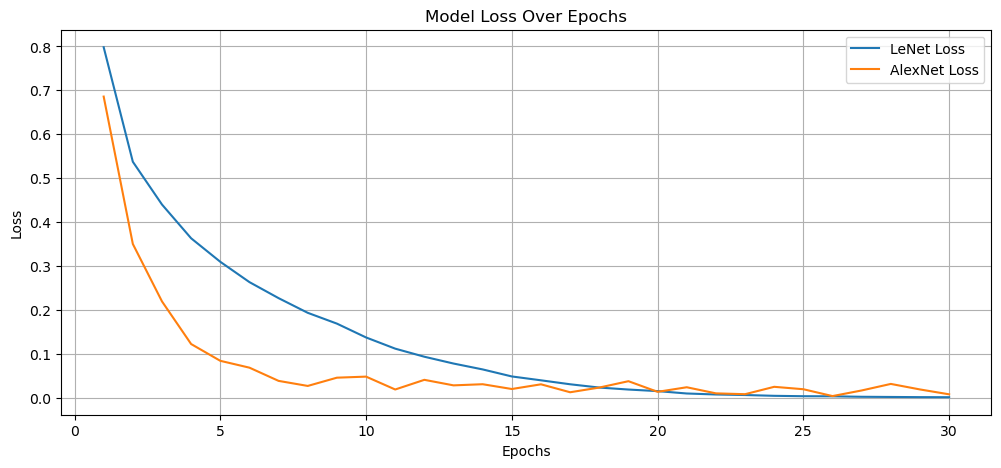

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: epochs and accuracy/loss values per epoch for 2 models (replace with your actual data)
epochs = np.arange(1, 31)

accuracy_data = {
    'LeNet': [0.6898, 0.7939, 0.8329, 0.8630, 0.8858, 0.9069, 0.9227, 0.9343, 0.9441, 0.9578, 0.9668, 0.9740, 0.9808, 0.9837, 0.9906, 0.9924, 0.9953, 0.9971, 0.9978, 0.9987, 0.9994, 0.9997, 0.9998, 0.9999, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0],
    'AlexNet': [0.7189, 0.8606, 0.9165, 0.9564, 0.9682, 0.9759, 0.9875, 0.9913, 0.9822, 0.9842, 0.9938, 0.9860, 0.9927, 0.9910, 0.9931, 0.9889, 0.9966, 0.9920, 0.9875, 0.9953, 0.9911, 0.9974, 0.9980, 0.9920, 0.9941, 0.9990, 0.9950, 0.9903, 0.9955, 0.9976]
}

loss_data = {
    'LeNet': [0.7982, 0.5374, 0.4400, 0.3631, 0.3096, 0.2633, 0.2268, 0.1934, 0.1688, 0.1373, 0.1118, 0.0934, 0.0779, 0.0645, 0.0485, 0.0397, 0.0307, 0.0232, 0.0187, 0.0151, 0.0097, 0.0074, 0.0062, 0.0044, 0.0035, 0.0033, 0.0022, 0.0018, 0.0014, 0.0012],
    'AlexNet': [0.6858, 0.3502, 0.2194, 0.1223, 0.0841, 0.0685, 0.0384, 0.0269, 0.0457, 0.0481, 0.0188, 0.0408, 0.0282, 0.0308, 0.0199, 0.0306, 0.0125, 0.0232, 0.0377, 0.0135, 0.0239, 0.0100, 0.0081, 0.0249, 0.0194, 0.0038, 0.0166, 0.0315, 0.0189, 0.0078]
}

# Plot accuracy comparison
plt.figure(figsize=(12, 5))
for model_name, accuracies in accuracy_data.items():
    plt.plot(epochs, accuracies, label=f'{model_name} Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss comparison
plt.figure(figsize=(12, 5))
for model_name, losses in loss_data.items():
    plt.plot(epochs, losses, label=f'{model_name} Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


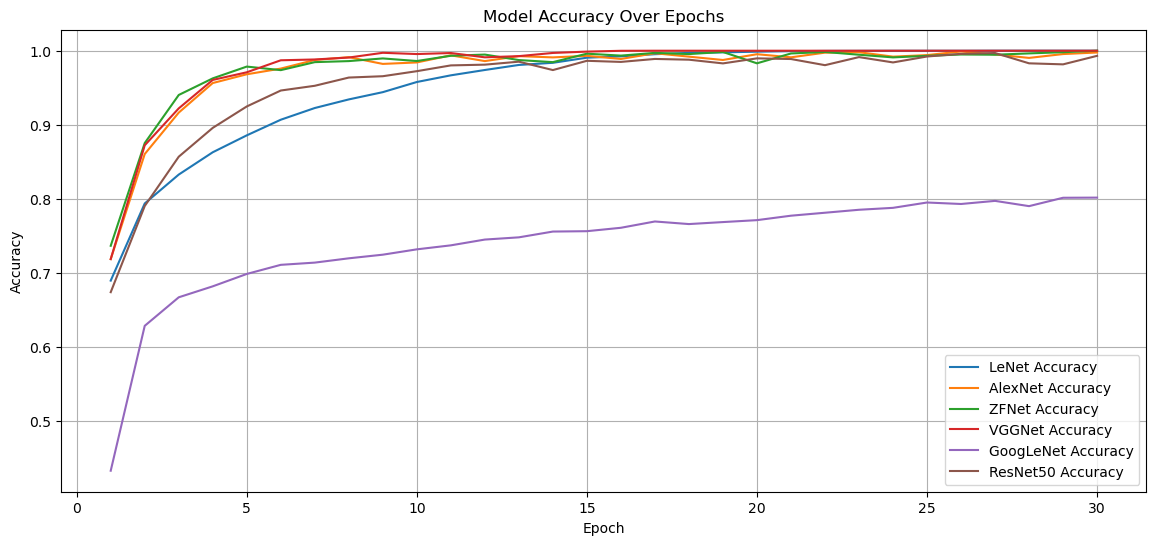

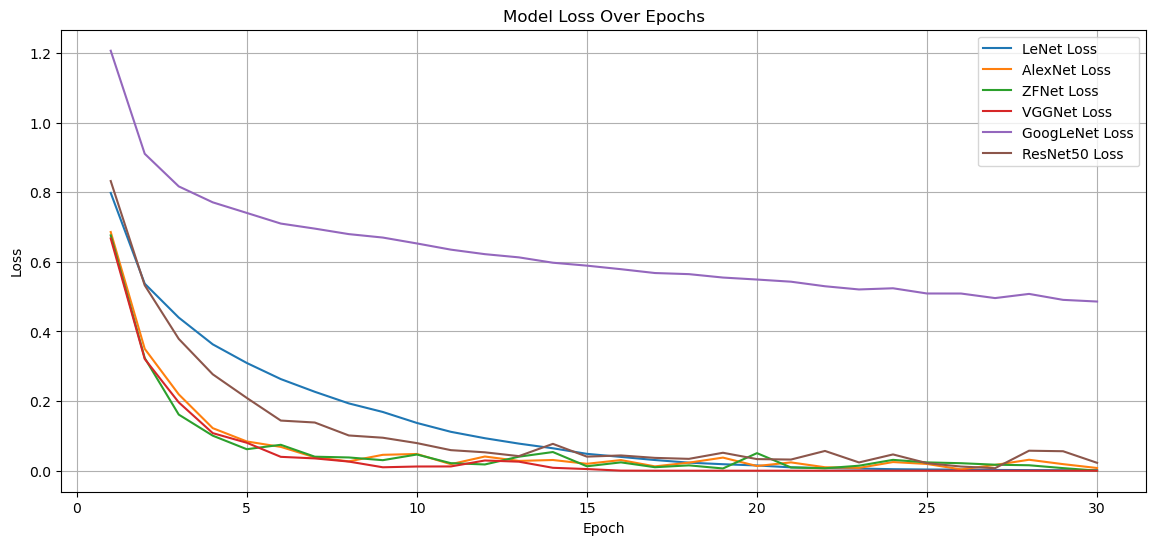

In [1]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 31)

accuracy_data = {
    'LeNet': [0.6898, 0.7939, 0.8329, 0.8630, 0.8858, 0.9069, 0.9227, 0.9343, 0.9441, 0.9578, 0.9668, 0.9740, 0.9808, 0.9837, 0.9906, 0.9924, 0.9953, 0.9971, 0.9978, 0.9987, 0.9994, 0.9997, 0.9998, 0.9999, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0],
    'AlexNet': [0.7189, 0.8606, 0.9165, 0.9564, 0.9682, 0.9759, 0.9875, 0.9913, 0.9822, 0.9842, 0.9938, 0.9860, 0.9927, 0.9910, 0.9931, 0.9889, 0.9966, 0.9920, 0.9875, 0.9953, 0.9911, 0.9974, 0.9980, 0.9920, 0.9941, 0.9990, 0.9950, 0.9903, 0.9955, 0.9976],
    'ZFNet': [0.7368, 0.8754, 0.9403, 0.9627, 0.9786, 0.9738, 0.9846, 0.9860, 0.9896, 0.9861, 0.9932, 0.9948, 0.9874, 0.9846, 0.9960, 0.9934, 0.9971, 0.9955, 0.9983, 0.9830, 0.9963, 0.9983, 0.9946, 0.9910, 0.9931, 0.9949, 0.9946, 0.9964, 0.9980, 1.0],
    'VGGNet': [0.7188, 0.8724, 0.9222, 0.9606, 0.9709, 0.9871, 0.9882, 0.9908, 0.9972, 0.9955, 0.9969, 0.9911, 0.9927, 0.9970, 0.9988, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'GoogLeNet': [0.4333, 0.6288, 0.6673, 0.6821, 0.6988, 0.7111, 0.7141, 0.7199, 0.7248, 0.7320, 0.7374, 0.7452, 0.7482, 0.7560, 0.7565, 0.7611, 0.7696, 0.7661, 0.7688, 0.7714, 0.7774, 0.7814, 0.7854, 0.7880, 0.7952, 0.7932, 0.7974, 0.7903, 0.8016, 0.8018],
    'ResNet50': [0.6742, 0.7905, 0.8570, 0.8959, 0.9248, 0.9463, 0.9527, 0.9638, 0.9656, 0.9724, 0.9802, 0.9812, 0.9852, 0.9739, 0.9864, 0.9849, 0.9889, 0.9879, 0.9829, 0.9897, 0.9888, 0.9805, 0.9914, 0.9842, 0.9922, 0.9958, 0.9969, 0.9830, 0.9816, 0.9931]
}

loss_data = {
    'LeNet': [0.7982, 0.5374, 0.4400, 0.3631, 0.3096, 0.2633, 0.2268, 0.1934, 0.1688, 0.1373, 0.1118, 0.0934, 0.0779, 0.0645, 0.0485, 0.0397, 0.0307, 0.0232, 0.0187, 0.0151, 0.0097, 0.0074, 0.0062, 0.0044, 0.0035, 0.0033, 0.0022, 0.0018, 0.0014, 0.0012],
    'AlexNet': [0.6858, 0.3502, 0.2194, 0.1223, 0.0841, 0.0685, 0.0384, 0.0269, 0.0457, 0.0481, 0.0188, 0.0408, 0.0282, 0.0308, 0.0199, 0.0306, 0.0125, 0.0232, 0.0377, 0.0135, 0.0239, 0.0100, 0.0081, 0.0249, 0.0194, 0.0038, 0.0166, 0.0315, 0.0189, 0.0078],
    'ZFNet': [0.6762, 0.3237, 0.1613, 0.1007, 0.0618, 0.0745, 0.0403, 0.0381, 0.0303, 0.0466, 0.0217, 0.0180, 0.0403, 0.0537, 0.0128, 0.0240, 0.0101, 0.0154, 0.0065, 0.0505, 0.0094, 0.0071, 0.0144, 0.0312, 0.0239, 0.0216, 0.0173, 0.0157, 0.0075, 0.00022],
    'VGGNet': [0.6673, 0.3211, 0.1964, 0.1080, 0.0804, 0.0399, 0.0354, 0.0263, 0.0099, 0.0121, 0.0123, 0.0294, 0.0260, 0.0084, 0.0048, 0.00028, 0.000028, 0.000018, 0.000013, 0.000010, 0.000008, 0.000007, 0.0000055, 0.0000045, 0.0000038, 0.0000031, 0.0000026, 0.0000022, 0.0000019, 0.0000016],
    'GoogLeNet': [1.2067, 0.9106, 0.8169, 0.7711, 0.7407, 0.7101, 0.6956, 0.6798, 0.6699, 0.6530, 0.6352, 0.6222, 0.6130, 0.5976, 0.5892, 0.5790, 0.5680, 0.5648, 0.5550, 0.5493, 0.5431, 0.5300, 0.5208, 0.5242, 0.5092, 0.5091, 0.4960, 0.5080, 0.4909, 0.4861],
    'ResNet50': [0.8323, 0.5327, 0.3788, 0.2770, 0.2092, 0.1441, 0.1385, 0.1013, 0.0948, 0.0794, 0.0591, 0.0529, 0.0419, 0.0772, 0.0405, 0.0439, 0.0369, 0.0341, 0.0516, 0.0334, 0.0321, 0.0568, 0.0238, 0.0468, 0.0217, 0.0120, 0.0073, 0.0575, 0.0560, 0.0227]
}

plt.figure(figsize=(14, 6))
for model, acc in accuracy_data.items():
    plt.plot(epochs, acc, label=f'{model} Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
for model, loss in loss_data.items():
    plt.plot(epochs, loss, label=f'{model} Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


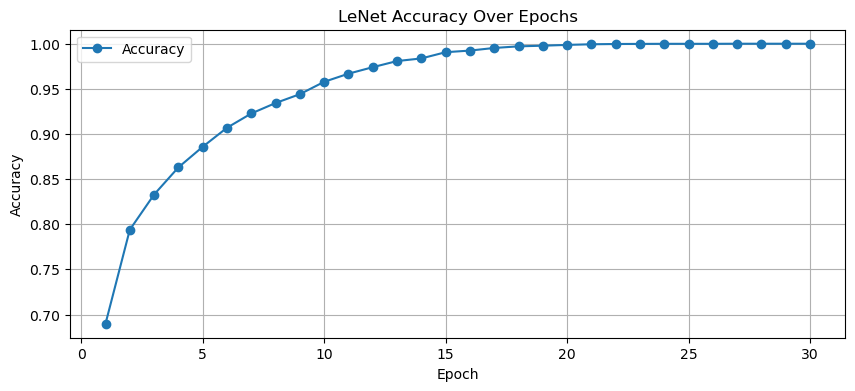

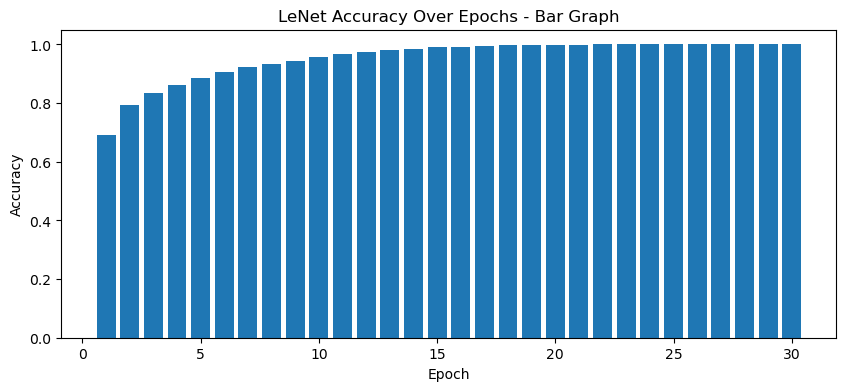

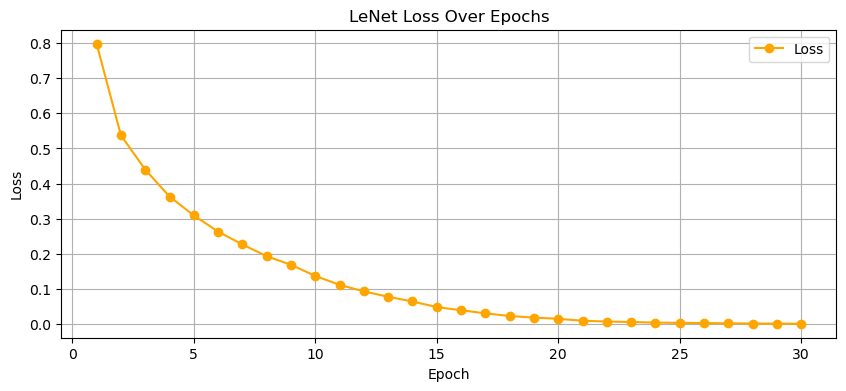

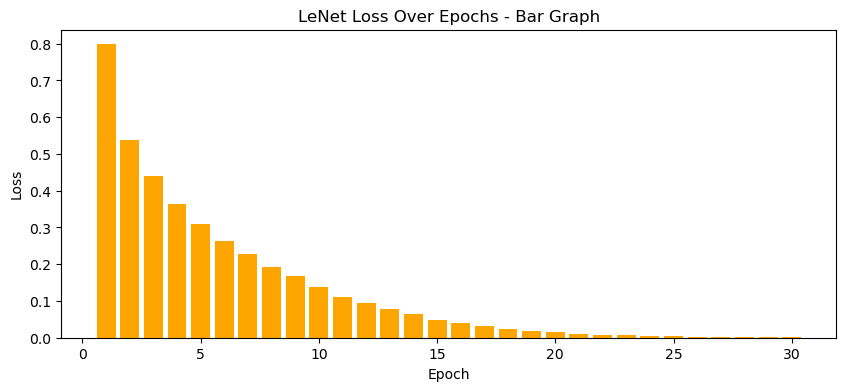

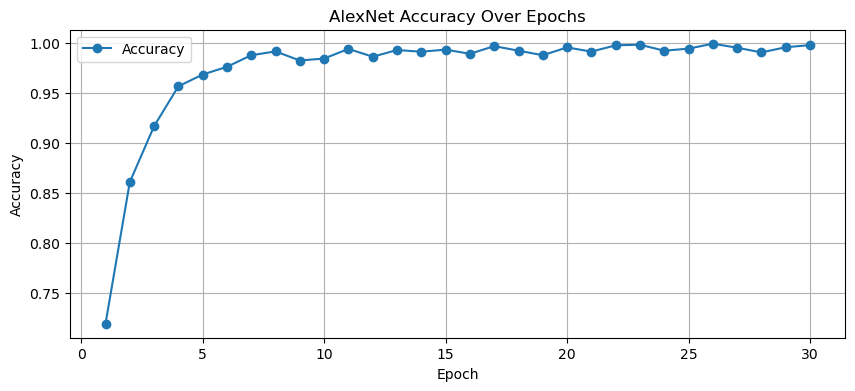

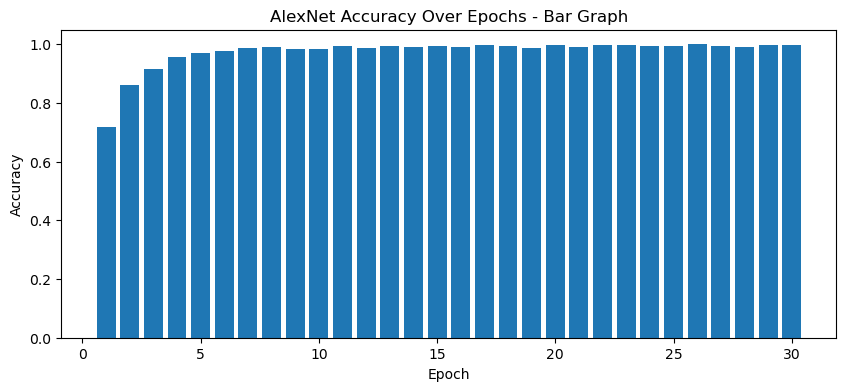

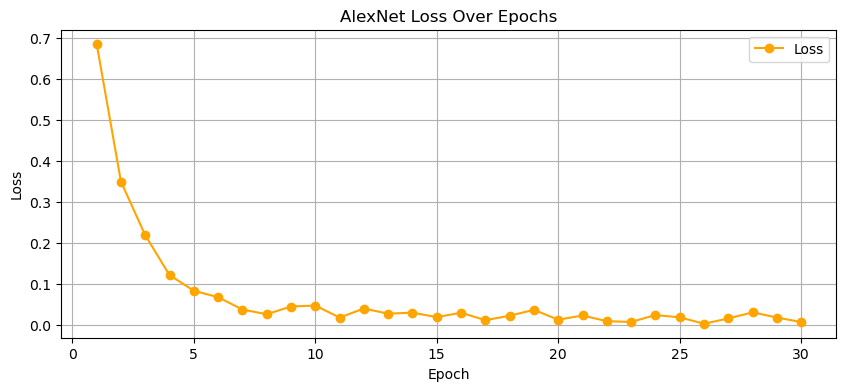

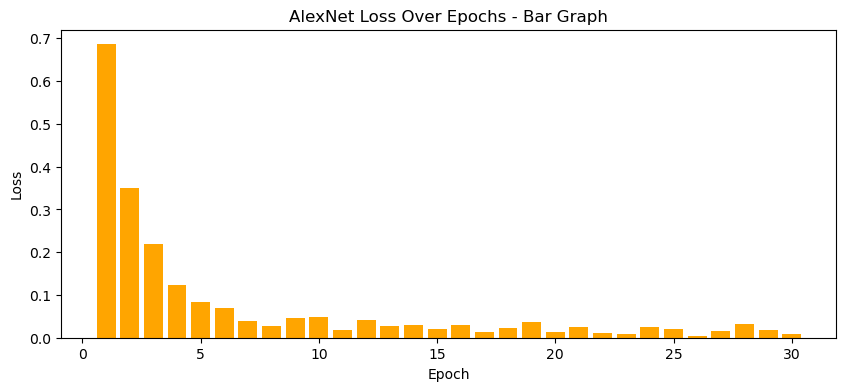

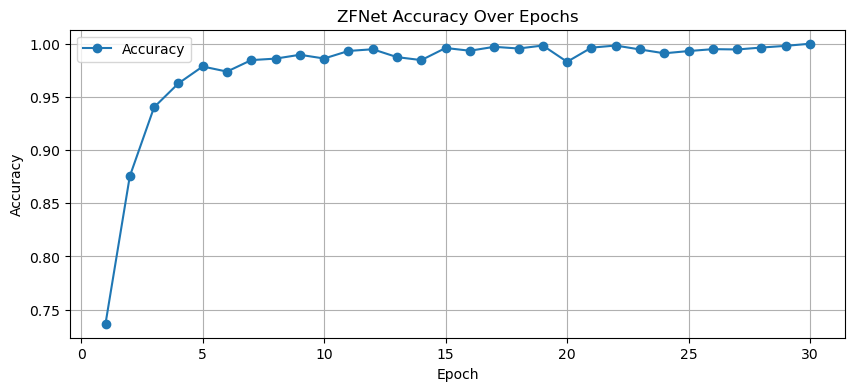

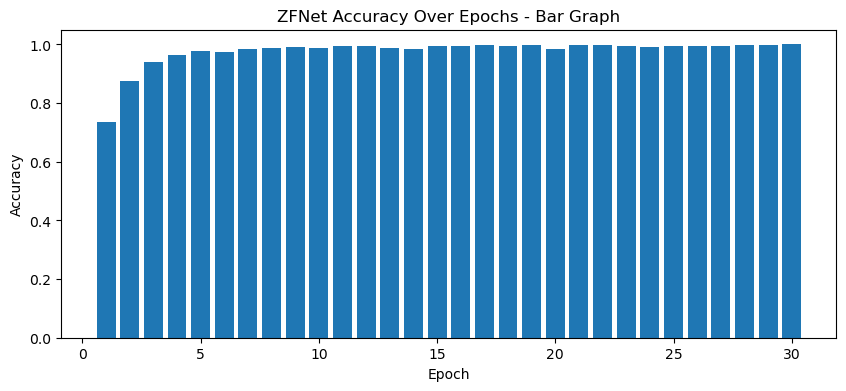

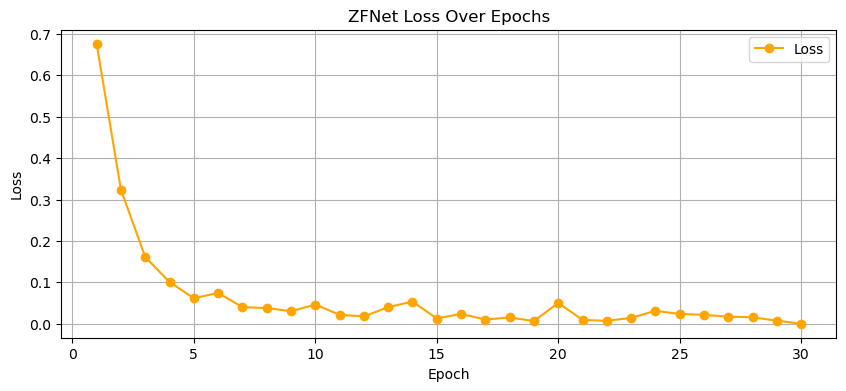

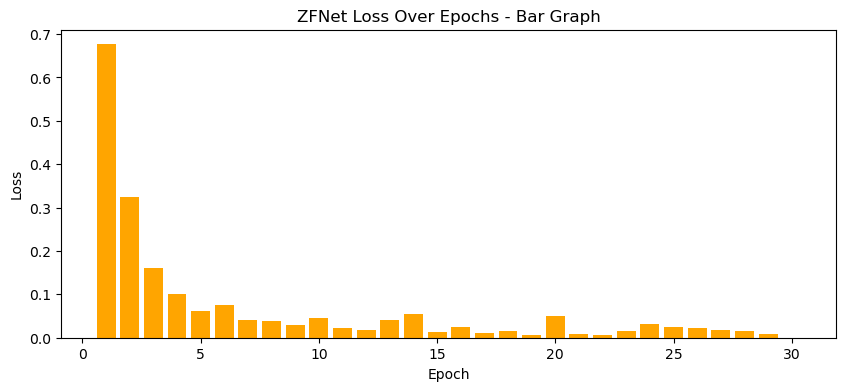

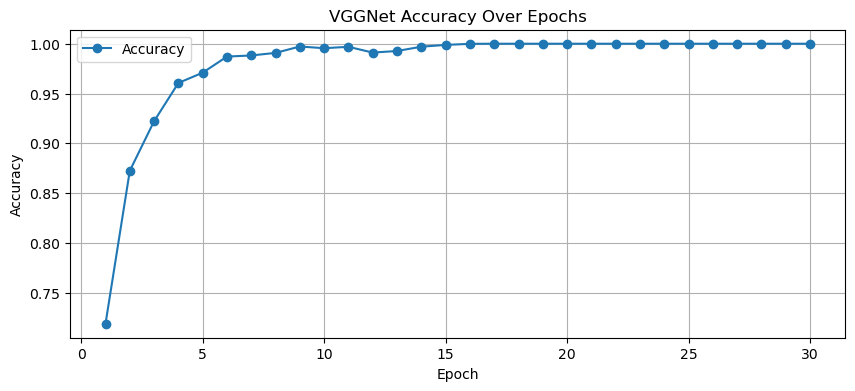

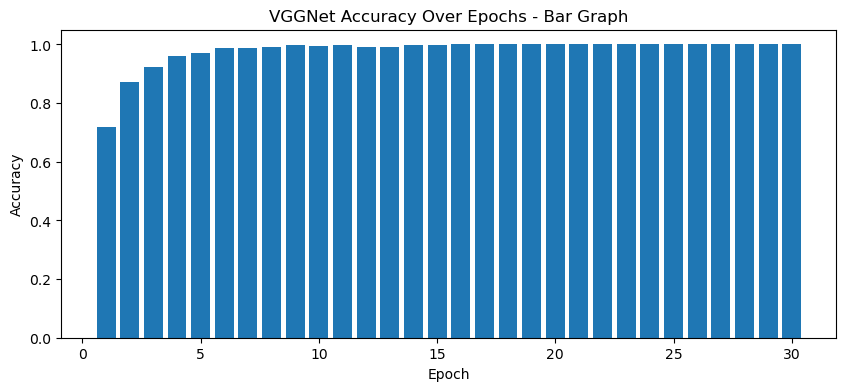

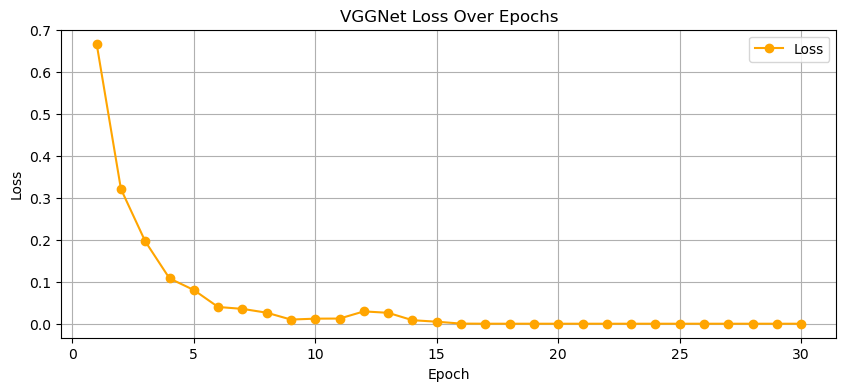

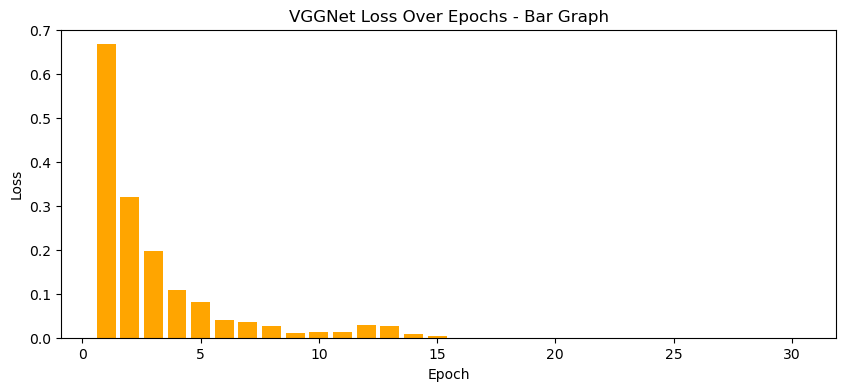

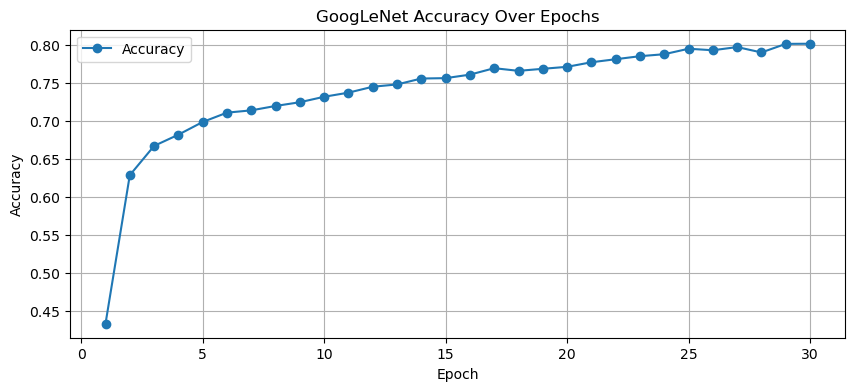

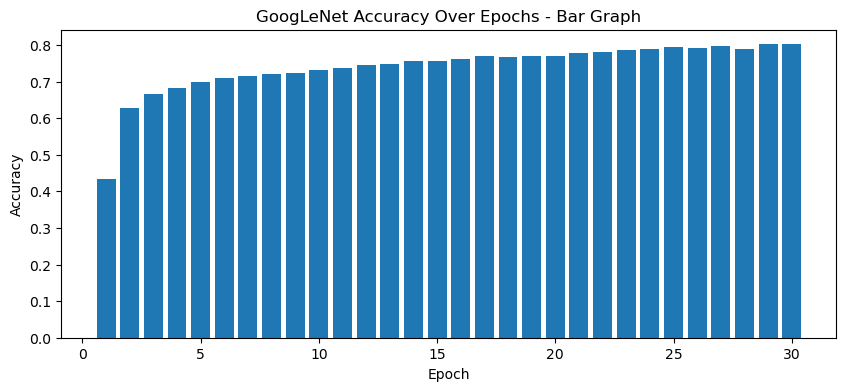

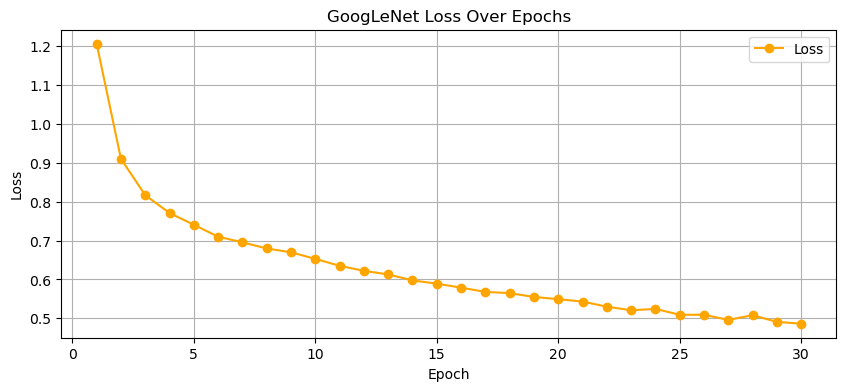

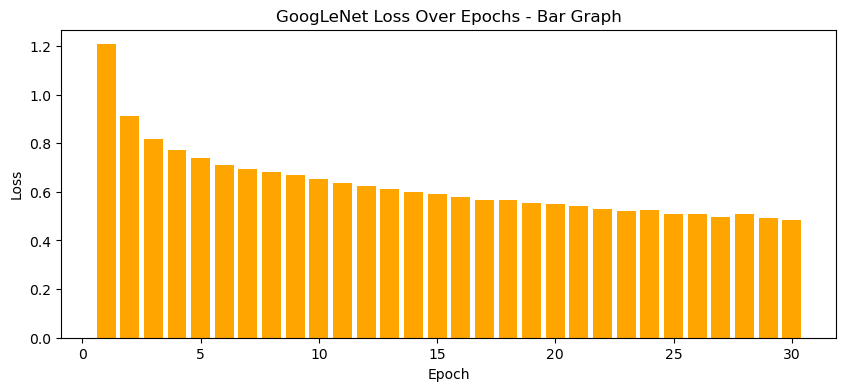

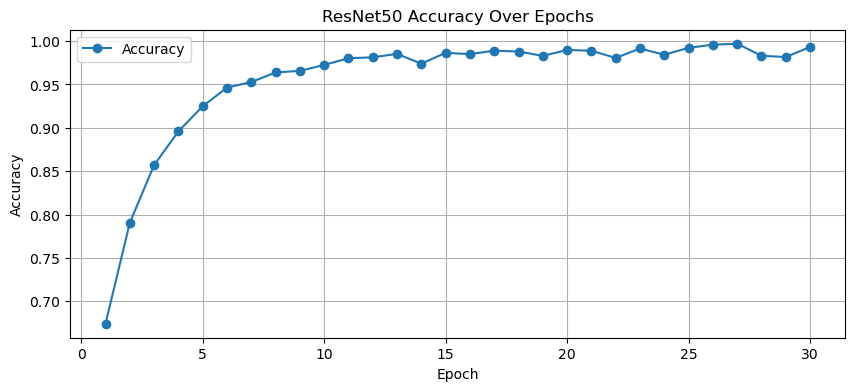

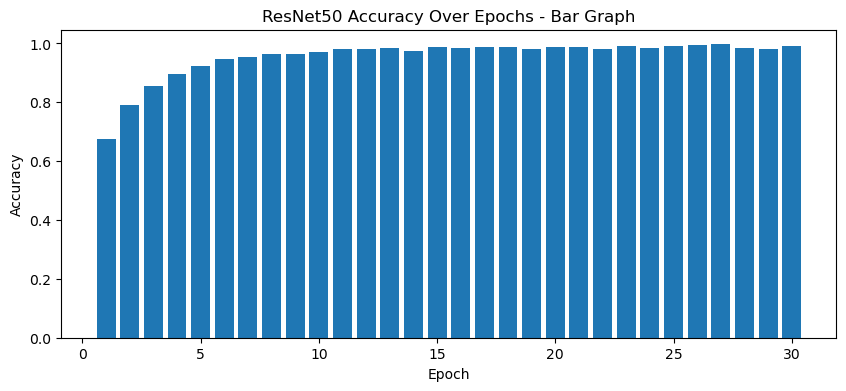

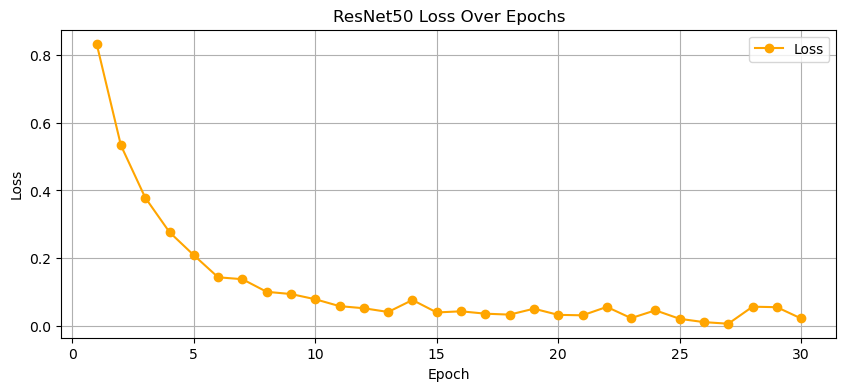

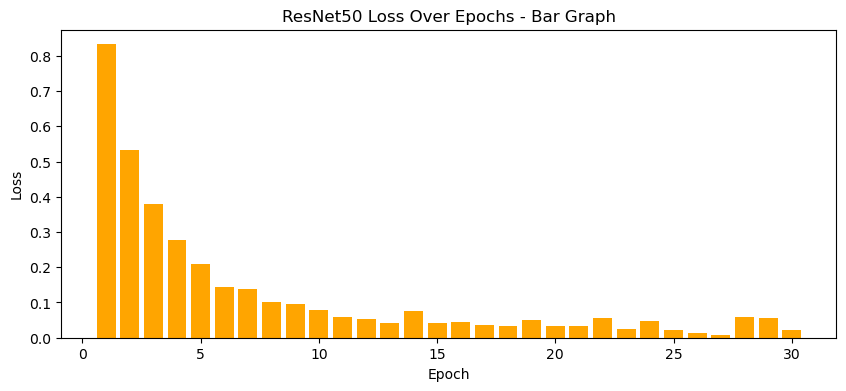

In [5]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 31)

accuracy_data = {
    'LeNet': [0.6898, 0.7939, 0.8329, 0.8630, 0.8858, 0.9069, 0.9227, 0.9343, 0.9441, 0.9578, 0.9668, 0.9740, 0.9808, 0.9837, 0.9906, 0.9924, 0.9953, 0.9971, 0.9978, 0.9987, 0.9994, 0.9997, 0.9998, 0.9999, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0],
    'AlexNet': [0.7189, 0.8606, 0.9165, 0.9564, 0.9682, 0.9759, 0.9875, 0.9913, 0.9822, 0.9842, 0.9938, 0.9860, 0.9927, 0.9910, 0.9931, 0.9889, 0.9966, 0.9920, 0.9875, 0.9953, 0.9911, 0.9974, 0.9980, 0.9920, 0.9941, 0.9990, 0.9950, 0.9903, 0.9955, 0.9976],
    'ZFNet': [0.7368, 0.8754, 0.9403, 0.9627, 0.9786, 0.9738, 0.9846, 0.9860, 0.9896, 0.9861, 0.9932, 0.9948, 0.9874, 0.9846, 0.9960, 0.9934, 0.9971, 0.9955, 0.9983, 0.9830, 0.9963, 0.9983, 0.9946, 0.9910, 0.9931, 0.9949, 0.9946, 0.9964, 0.9980, 1.0],
    'VGGNet': [0.7188, 0.8724, 0.9222, 0.9606, 0.9709, 0.9871, 0.9882, 0.9908, 0.9972, 0.9955, 0.9969, 0.9911, 0.9927, 0.9970, 0.9988, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'GoogLeNet': [0.4333, 0.6288, 0.6673, 0.6821, 0.6988, 0.7111, 0.7141, 0.7199, 0.7248, 0.7320, 0.7374, 0.7452, 0.7482, 0.7560, 0.7565, 0.7611, 0.7696, 0.7661, 0.7688, 0.7714, 0.7774, 0.7814, 0.7854, 0.7880, 0.7952, 0.7932, 0.7974, 0.7903, 0.8016, 0.8018],
    'ResNet50': [0.6742, 0.7905, 0.8570, 0.8959, 0.9248, 0.9463, 0.9527, 0.9638, 0.9656, 0.9724, 0.9802, 0.9812, 0.9852, 0.9739, 0.9864, 0.9849, 0.9889, 0.9879, 0.9829, 0.9897, 0.9888, 0.9805, 0.9914, 0.9842, 0.9922, 0.9958, 0.9969, 0.9830, 0.9816, 0.9931]
}

loss_data = {
    'LeNet': [0.7982, 0.5374, 0.4400, 0.3631, 0.3096, 0.2633, 0.2268, 0.1934, 0.1688, 0.1373, 0.1118, 0.0934, 0.0779, 0.0645, 0.0485, 0.0397, 0.0307, 0.0232, 0.0187, 0.0151, 0.0097, 0.0074, 0.0062, 0.0044, 0.0035, 0.0033, 0.0022, 0.0018, 0.0014, 0.0012],
    'AlexNet': [0.6858, 0.3502, 0.2194, 0.1223, 0.0841, 0.0685, 0.0384, 0.0269, 0.0457, 0.0481, 0.0188, 0.0408, 0.0282, 0.0308, 0.0199, 0.0306, 0.0125, 0.0232, 0.0377, 0.0135, 0.0239, 0.0100, 0.0081, 0.0249, 0.0194, 0.0038, 0.0166, 0.0315, 0.0189, 0.0078],
    'ZFNet': [0.6762, 0.3237, 0.1613, 0.1007, 0.0618, 0.0745, 0.0403, 0.0381, 0.0303, 0.0466, 0.0217, 0.0180, 0.0403, 0.0537, 0.0128, 0.0240, 0.0101, 0.0154, 0.0065, 0.0505, 0.0094, 0.0071, 0.0144, 0.0312, 0.0239, 0.0216, 0.0173, 0.0157, 0.0075, 0.0002],
    'VGGNet': [0.6673, 0.3211, 0.1964, 0.1080, 0.0804, 0.0399, 0.0354, 0.0263, 0.0099, 0.0121, 0.0123, 0.0294, 0.0260, 0.0084, 0.0048, 0.0003, 0.00003, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001],
    'GoogLeNet': [1.2067, 0.9106, 0.8169, 0.7711, 0.7407, 0.7101, 0.6956, 0.6798, 0.6699, 0.6530, 0.6352, 0.6222, 0.6130, 0.5976, 0.5892, 0.5790, 0.5680, 0.5648, 0.5550, 0.5493, 0.5431, 0.5300, 0.5208, 0.5242, 0.5092, 0.5091, 0.4960, 0.5080, 0.4909, 0.4861],
    'ResNet50': [0.8323, 0.5327, 0.3788, 0.2770, 0.2092, 0.1441, 0.1385, 0.1013, 0.0948, 0.0794, 0.0591, 0.0529, 0.0419, 0.0772, 0.0405, 0.0439, 0.0369, 0.0341, 0.0516, 0.0334, 0.0321, 0.0568, 0.0238, 0.0468, 0.0217, 0.0120, 0.0073, 0.0575, 0.0560, 0.0227]
}

import matplotlib.pyplot as plt

for model in accuracy_data.keys():
    # Accuracy Line Plot
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, accuracy_data[model], marker='o', label='Accuracy')
    plt.title(f"{model} Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Accuracy Bar Graph
    plt.figure(figsize=(10, 4))
    plt.bar(epochs, accuracy_data[model])
    plt.title(f"{model} Accuracy Over Epochs - Bar Graph")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    # Loss Line Plot
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, loss_data[model], marker='o', color='orange', label='Loss')
    plt.title(f"{model} Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Loss Bar Graph
    plt.figure(figsize=(10, 4))
    plt.bar(epochs, loss_data[model], color='orange')
    plt.title(f"{model} Loss Over Epochs - Bar Graph")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


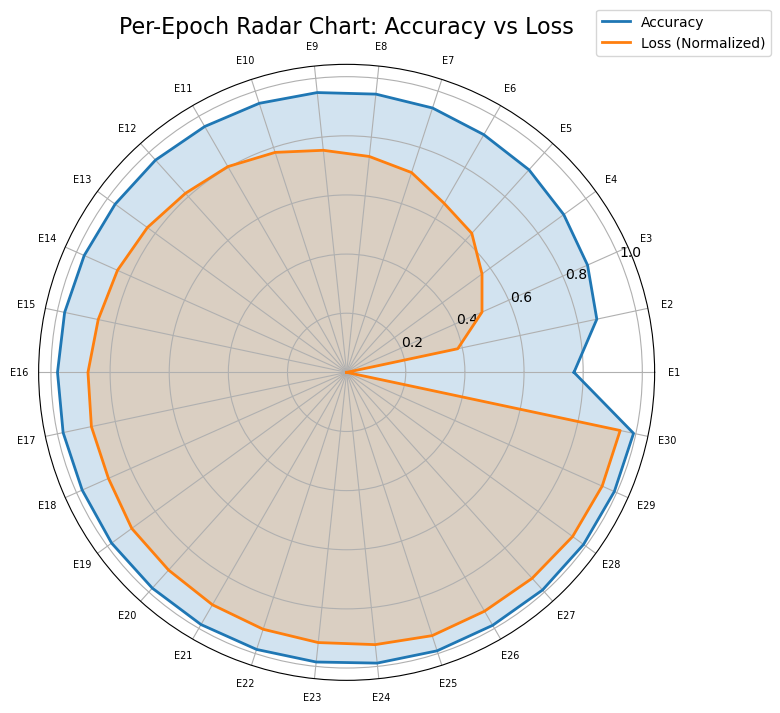

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Replace these with your data
# ---------------------------
epochs = list(range(1, 31))
accuracy = [0.7689,0.8651,0.8919,0.9077,0.9218,0.9282,0.9401,0.9462,0.9515,0.9567,
            0.9601,0.9661,0.9678,0.9716,0.9751,0.9779,0.9803,0.9790,0.9826,0.9822,
            0.9850,0.9854,0.9851,0.9888,0.9903,0.9879,0.9904,0.9904,0.9911,0.9921]

loss = [0.5984,0.3685,0.2985,0.2597,0.2198,0.2035,0.1732,0.1591,0.1465,0.1303,
        0.1176,0.1108,0.0999,0.0907,0.0844,0.0749,0.0703,0.0707,0.0609,0.0599,
        0.0552,0.0517,0.0485,0.0443,0.0381,0.0402,0.0374,0.0331,0.0323,0.0324]

# Normalize loss so radar chart scales properly
loss_norm = (max(loss) - np.array(loss)) / max(loss)

# Angles for radar
angles = np.linspace(0, 2*np.pi, len(epochs), endpoint=False).tolist()
angles += angles[:1]

acc_values = accuracy + accuracy[:1]
loss_values = loss_norm.tolist() + loss_norm.tolist()[:1]

# ----------------
# Plot Radar Chart
# ----------------
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], [f"E{e}" for e in epochs], fontsize=7)

# Plot Accuracy
acc_line, = ax.plot(angles, acc_values, linewidth=2, label="Accuracy")
ax.fill(angles, acc_values, alpha=0.2)

# Plot Loss
loss_line, = ax.plot(angles, loss_values, linewidth=2, label="Loss (Normalized)")
ax.fill(angles, loss_values, alpha=0.2)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.title("Per-Epoch Radar Chart: Accuracy vs Loss", fontsize=16)
plt.show()

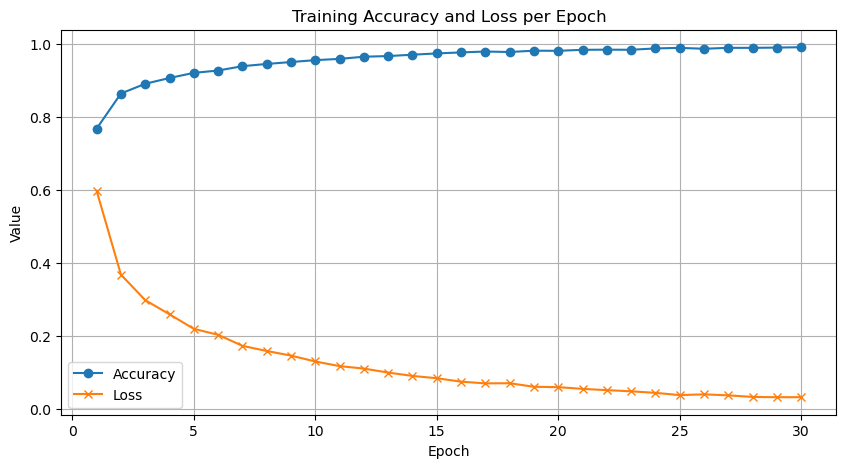

In [2]:
import matplotlib.pyplot as plt

epochs = list(range(1, 31))

plt.figure(figsize=(10,5))
plt.plot(epochs, accuracy, label="Accuracy", marker='o')
plt.plot(epochs, loss, label="Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Accuracy and Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

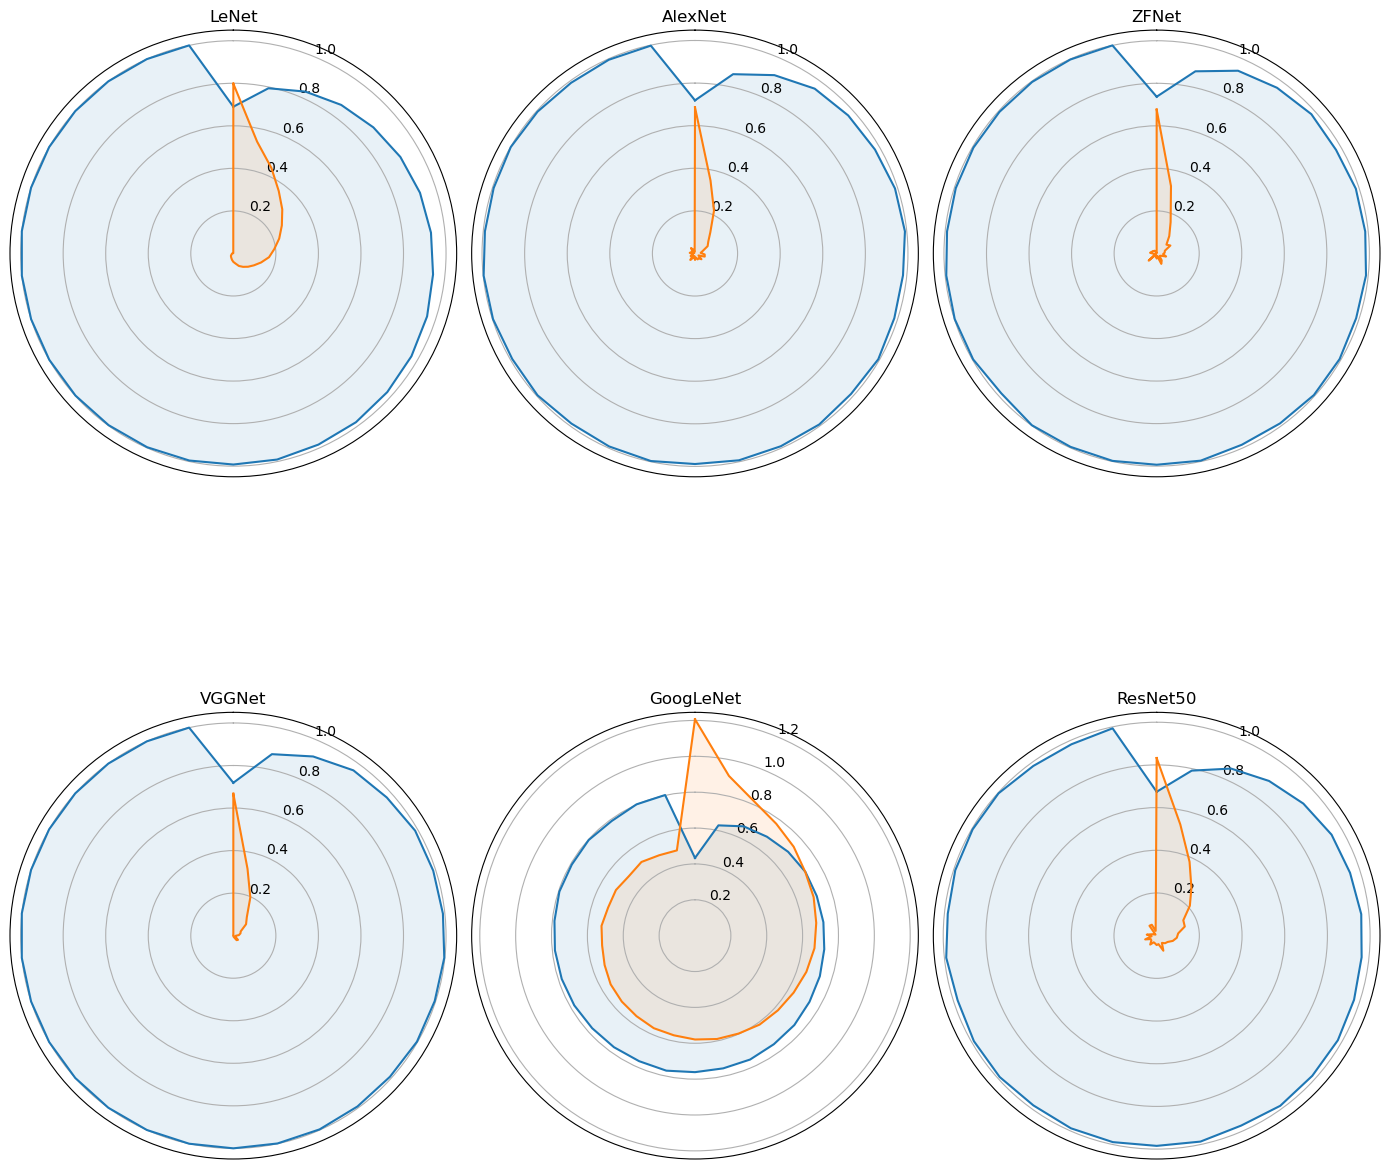

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# INSERT YOUR VALUES HERE
# =============================

epochs = np.arange(1, 31)

# ---- LeNet ----
lenet_acc = [0.6898, 0.7939, 0.8329, 0.8630, 0.8858, 0.9069, 0.9227, 0.9343, 0.9441, 0.9578, 0.9668, 0.9740, 0.9808, 0.9837, 0.9906, 0.9924, 0.9953, 0.9971, 0.9978, 0.9987, 0.9994, 0.9997, 0.9998, 0.9999, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0]

lenet_loss = [0.7982, 0.5374, 0.4400, 0.3631, 0.3096, 0.2633, 0.2268, 0.1934, 0.1688, 0.1373, 0.1118, 0.0934, 0.0779, 0.0645, 0.0485, 0.0397, 0.0307, 0.0232, 0.0187, 0.0151, 0.0097, 0.0074, 0.0062, 0.0044, 0.0035, 0.0033, 0.0022, 0.0018, 0.0014, 0.0012]
    

# ---- AlexNet ----
alex_acc = [0.7189, 0.8606, 0.9165, 0.9564, 0.9682, 0.9759, 0.9875, 0.9913, 0.9822, 0.9842, 0.9938, 0.9860, 0.9927, 0.9910, 0.9931, 0.9889, 0.9966, 0.9920, 0.9875, 0.9953, 0.9911, 0.9974, 0.9980, 0.9920, 0.9941, 0.9990, 0.9950, 0.9903, 0.9955, 0.9976]
    
alex_loss = [0.6858, 0.3502, 0.2194, 0.1223, 0.0841, 0.0685, 0.0384, 0.0269, 0.0457, 0.0481, 0.0188, 0.0408, 0.0282, 0.0308, 0.0199, 0.0306, 0.0125, 0.0232, 0.0377, 0.0135, 0.0239, 0.0100, 0.0081, 0.0249, 0.0194, 0.0038, 0.0166, 0.0315, 0.0189, 0.0078]
    
zfnet_acc = [0.7368, 0.8754, 0.9403, 0.9627, 0.9786, 0.9738, 0.9846, 0.9860, 0.9896, 0.9861, 0.9932, 0.9948, 0.9874, 0.9846, 0.9960, 0.9934, 0.9971, 0.9955, 0.9983, 0.9830, 0.9963, 0.9983, 0.9946, 0.9910, 0.9931, 0.9949, 0.9946, 0.9964, 0.9980, 1.0]
zfnet_loss = [0.6762, 0.3237, 0.1613, 0.1007, 0.0618, 0.0745, 0.0403, 0.0381, 0.0303, 0.0466, 0.0217, 0.0180, 0.0403, 0.0537, 0.0128, 0.0240, 0.0101, 0.0154, 0.0065, 0.0505, 0.0094, 0.0071, 0.0144, 0.0312, 0.0239, 0.0216, 0.0173, 0.0157, 0.0075, 0.0002]
    

vgg_acc = [0.7188, 0.8724, 0.9222, 0.9606, 0.9709, 0.9871, 0.9882, 0.9908, 0.9972, 0.9955, 0.9969, 0.9911, 0.9927, 0.9970, 0.9988, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
vgg_loss = [0.6673, 0.3211, 0.1964, 0.1080, 0.0804, 0.0399, 0.0354, 0.0263, 0.0099, 0.0121, 0.0123, 0.0294, 0.0260, 0.0084, 0.0048, 0.0003, 0.00003, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001]
    

googlenet_acc = [0.4333, 0.6288, 0.6673, 0.6821, 0.6988, 0.7111, 0.7141, 0.7199, 0.7248, 0.7320, 0.7374, 0.7452, 0.7482, 0.7560, 0.7565, 0.7611, 0.7696, 0.7661, 0.7688, 0.7714, 0.7774, 0.7814, 0.7854, 0.7880, 0.7952, 0.7932, 0.7974, 0.7903, 0.8016, 0.8018]
    
googlenet_loss = [1.2067, 0.9106, 0.8169, 0.7711, 0.7407, 0.7101, 0.6956, 0.6798, 0.6699, 0.6530, 0.6352, 0.6222, 0.6130, 0.5976, 0.5892, 0.5790, 0.5680, 0.5648, 0.5550, 0.5493, 0.5431, 0.5300, 0.5208, 0.5242, 0.5092, 0.5091, 0.4960, 0.5080, 0.4909, 0.4861]
    

resnet_acc = [0.6742, 0.7905, 0.8570, 0.8959, 0.9248, 0.9463, 0.9527, 0.9638, 0.9656, 0.9724, 0.9802, 0.9812, 0.9852, 0.9739, 0.9864, 0.9849, 0.9889, 0.9879, 0.9829, 0.9897, 0.9888, 0.9805, 0.9914, 0.9842, 0.9922, 0.9958, 0.9969, 0.9830, 0.9816, 0.9931]

resnet_loss = [0.8323, 0.5327, 0.3788, 0.2770, 0.2092, 0.1441, 0.1385, 0.1013, 0.0948, 0.0794, 0.0591, 0.0529, 0.0419, 0.0772, 0.0405, 0.0439, 0.0369, 0.0341, 0.0516, 0.0334, 0.0321, 0.0568, 0.0238, 0.0468, 0.0217, 0.0120, 0.0073, 0.0575, 0.0560, 0.0227]



# ====================
# Radar Chart Function
# ====================
def radar(ax, values1, values2, title):
    angles = np.linspace(0, 2*np.pi, len(values1), endpoint=False).tolist()
    angles += angles[:1]

    v1 = values1 + values1[:1]
    v2 = values2 + values2[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles, v1, linewidth=1.5)
    ax.fill(angles, v1, alpha=0.1)

    ax.plot(angles, v2, linewidth=1.5)
    ax.fill(angles, v2, alpha=0.1)

    ax.set_title(title, size=12)
    ax.set_xticks([])


# ============
# PLOTTING
# ============
fig, axs = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 16))

models = [
    ("LeNet", lenet_acc, lenet_loss),
    ("AlexNet", alex_acc, alex_loss),
    ("ZFNet", zfnet_acc, zfnet_loss),
    ("VGGNet", vgg_acc, vgg_loss),
    ("GoogLeNet", googlenet_acc, googlenet_loss),
    ("ResNet50", resnet_acc, resnet_loss),
]

idx = 0
for r in range(2):
    for c in range(3):
        name, acc, loss = models[idx]
        radar(axs[r][c], acc, loss, name)
        idx += 1

plt.tight_layout()
plt.show()


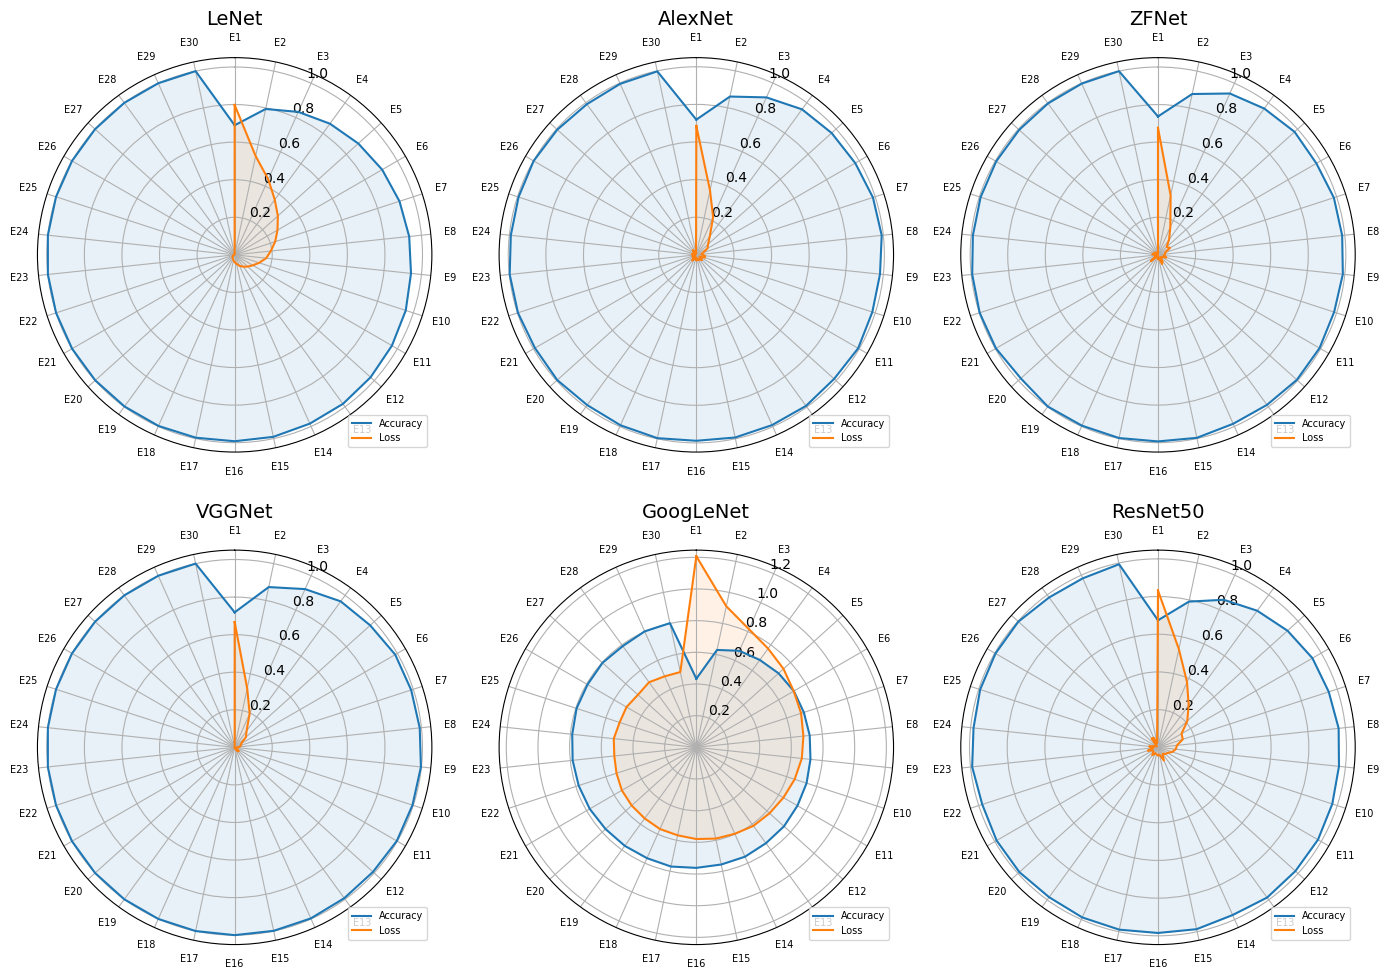

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# INSERT YOUR VALUES HERE
# =============================

epochs = np.arange(1, 31)

# ---- LeNet ----
lenet_acc = [0.6898, 0.7939, 0.8329, 0.8630, 0.8858, 0.9069, 0.9227, 0.9343, 0.9441, 0.9578,
             0.9668, 0.9740, 0.9808, 0.9837, 0.9906, 0.9924, 0.9953, 0.9971, 0.9978, 0.9987,
             0.9994, 0.9997, 0.9998, 0.9999, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0]

lenet_loss = [0.7982, 0.5374, 0.4400, 0.3631, 0.3096, 0.2633, 0.2268, 0.1934, 0.1688, 0.1373,
              0.1118, 0.0934, 0.0779, 0.0645, 0.0485, 0.0397, 0.0307, 0.0232, 0.0187, 0.0151,
              0.0097, 0.0074, 0.0062, 0.0044, 0.0035, 0.0033, 0.0022, 0.0018, 0.0014, 0.0012]


# ---- AlexNet ----
alex_acc = [0.7189, 0.8606, 0.9165, 0.9564, 0.9682, 0.9759, 0.9875, 0.9913, 0.9822, 0.9842,
            0.9938, 0.9860, 0.9927, 0.9910, 0.9931, 0.9889, 0.9966, 0.9920, 0.9875, 0.9953,
            0.9911, 0.9974, 0.9980, 0.9920, 0.9941, 0.9990, 0.9950, 0.9903, 0.9955, 0.9976]

alex_loss = [0.6858, 0.3502, 0.2194, 0.1223, 0.0841, 0.0685, 0.0384, 0.0269, 0.0457, 0.0481,
             0.0188, 0.0408, 0.0282, 0.0308, 0.0199, 0.0306, 0.0125, 0.0232, 0.0377, 0.0135,
             0.0239, 0.0100, 0.0081, 0.0249, 0.0194, 0.0038, 0.0166, 0.0315, 0.0189, 0.0078]


# ---- ZFNet ----
zfnet_acc = [0.7368, 0.8754, 0.9403, 0.9627, 0.9786, 0.9738, 0.9846, 0.9860, 0.9896, 0.9861,
             0.9932, 0.9948, 0.9874, 0.9846, 0.9960, 0.9934, 0.9971, 0.9955, 0.9983, 0.9830,
             0.9963, 0.9983, 0.9946, 0.9910, 0.9931, 0.9949, 0.9946, 0.9964, 0.9980, 1.0]

zfnet_loss = [0.6762, 0.3237, 0.1613, 0.1007, 0.0618, 0.0745, 0.0403, 0.0381, 0.0303, 0.0466,
              0.0217, 0.0180, 0.0403, 0.0537, 0.0128, 0.0240, 0.0101, 0.0154, 0.0065, 0.0505,
              0.0094, 0.0071, 0.0144, 0.0312, 0.0239, 0.0216, 0.0173, 0.0157, 0.0075, 0.0002]


# ---- VGGNet ----
vgg_acc = [0.7188, 0.8724, 0.9222, 0.9606, 0.9709, 0.9871, 0.9882, 0.9908, 0.9972, 0.9955,
           0.9969, 0.9911, 0.9927, 0.9970, 0.9988, 0.9999, 1.0, 1.0, 1.0, 1.0,
           1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

vgg_loss = [0.6673, 0.3211, 0.1964, 0.1080, 0.0804, 0.0399, 0.0354, 0.0263, 0.0099, 0.0121,
            0.0123, 0.0294, 0.0260, 0.0084, 0.0048, 0.0003, 0.00003, 0.00002, 0.00001, 0.00001,
            0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001]


# ---- GoogLeNet ----
googlenet_acc = [0.4333, 0.6288, 0.6673, 0.6821, 0.6988, 0.7111, 0.7141, 0.7199, 0.7248, 0.7320,
                 0.7374, 0.7452, 0.7482, 0.7560, 0.7565, 0.7611, 0.7696, 0.7661, 0.7688, 0.7714,
                 0.7774, 0.7814, 0.7854, 0.7880, 0.7952, 0.7932, 0.7974, 0.7903, 0.8016, 0.8018]

googlenet_loss = [1.2067, 0.9106, 0.8169, 0.7711, 0.7407, 0.7101, 0.6956, 0.6798, 0.6699, 0.6530,
                  0.6352, 0.6222, 0.6130, 0.5976, 0.5892, 0.5790, 0.5680, 0.5648, 0.5550, 0.5493,
                  0.5431, 0.5300, 0.5208, 0.5242, 0.5092, 0.5091, 0.4960, 0.5080, 0.4909, 0.4861]


# ---- ResNet50 ----
resnet_acc = [0.6742, 0.7905, 0.8570, 0.8959, 0.9248, 0.9463, 0.9527, 0.9638, 0.9656, 0.9724,
              0.9802, 0.9812, 0.9852, 0.9739, 0.9864, 0.9849, 0.9889, 0.9879, 0.9829, 0.9897,
              0.9888, 0.9805, 0.9914, 0.9842, 0.9922, 0.9958, 0.9969, 0.9830, 0.9816, 0.9931]

resnet_loss = [0.8323, 0.5327, 0.3788, 0.2770, 0.2092, 0.1441, 0.1385, 0.1013, 0.0948, 0.0794,
               0.0591, 0.0529, 0.0419, 0.0772, 0.0405, 0.0439, 0.0369, 0.0341, 0.0516, 0.0334,
               0.0321, 0.0568, 0.0238, 0.0468, 0.0217, 0.0120, 0.0073, 0.0575, 0.0560, 0.0227]


# ====================
# Radar Chart Function
# ====================
def radar(ax, values1, values2, title):
    labels = [f"E{e}" for e in range(1, len(values1)+1)]

    angles = np.linspace(0, 2*np.pi, len(values1), endpoint=False).tolist()
    angles += angles[:1]

    v1 = values1 + values1[:1]
    v2 = values2 + values2[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles, v1, linewidth=1.5, label="Accuracy")
    ax.fill(angles, v1, alpha=0.1)

    ax.plot(angles, v2, linewidth=1.5, label="Loss")
    ax.fill(angles, v2, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=7)

    ax.set_title(title, size=14)
    ax.legend(loc='lower right', fontsize=7)


# ============
# PLOTTING
# ============
fig, axs = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 10))

models = [
    ("LeNet", lenet_acc, lenet_loss),
    ("AlexNet", alex_acc, alex_loss),
    ("ZFNet", zfnet_acc, zfnet_loss),
    ("VGGNet", vgg_acc, vgg_loss),
    ("GoogLeNet", googlenet_acc, googlenet_loss),
    ("ResNet50", resnet_acc, resnet_loss),
]

idx = 0
for r in range(2):
    for c in range(3):
        name, acc, loss = models[idx]
        radar(axs[r][c], acc, loss, name)
        idx += 1

plt.tight_layout()
plt.show()


# Model Validation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import numpy as np

# --- GLOBAL PARAMETERS ---
DATA_DIR_TRAIN = r'C:/Users/tusha/OneDrive/Desktop/Training'
DATA_DIR_TEST = r'C:/Users/tusha/OneDrive/Desktop/Testing'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123
EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_CLASSES_4_CLASS = 4  # Glioma, Meningioma, Pituitary, No Tumor

print("--- Step 1: Loading Data (4-Class Setup) ---")

# Load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR_TRAIN,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Load test/validation data
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR_TEST,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Convert dataset to numpy arrays
def dataset_to_numpy(ds):
    images = []
    labels = []
    for batch in ds:
        x, y = batch
        images.append(x.numpy())
        labels.append(y.numpy())
    return np.concatenate(images), np.concatenate(labels)

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CLASSES_4_CLASS)
y_test_cat = to_categorical(y_test, NUM_CLASSES_4_CLASS)

# --- Define LeNet Model ---
def LeNet():
    model = models.Sequential([
        layers.Conv2D(6, kernel_size=5, activation='tanh', input_shape=IMG_SIZE + (3,)),
        layers.AveragePooling2D(pool_size=2),
        layers.Conv2D(16, kernel_size=5, activation='tanh'),
        layers.AveragePooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(NUM_CLASSES_4_CLASS, activation='softmax')
    ])
    return model

# --- Build and Train LeNet ---
print("\nTraining LeNet...")
model = LeNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train_cat,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2)

# --- Evaluate Model ---
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nLeNet Test Accuracy: {test_acc:.4f}")

--- Step 1: Loading Data (4-Class Setup) ---
Found 8582 files belonging to 4 classes.
Found 1705 files belonging to 4 classes.

Training LeNet...


C:\Users\tusha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
269/269 - 8s - 29ms/step - accuracy: 0.6998 - loss: 0.7740
Epoch 2/30
269/269 - 6s - 21ms/step - accuracy: 0.8093 - loss: 0.5090
Epoch 3/30
269/269 - 5s - 20ms/step - accuracy: 0.8471 - loss: 0.4123
Epoch 4/30
269/269 - 5s - 20ms/step - accuracy: 0.8766 - loss: 0.3421
Epoch 5/30
269/269 - 5s - 20ms/step - accuracy: 0.8983 - loss: 0.2881
Epoch 6/30
269/269 - 6s - 21ms/step - accuracy: 0.9154 - loss: 0.2463
Epoch 7/30
269/269 - 6s - 21ms/step - accuracy: 0.9279 - loss: 0.2087
Epoch 8/30
269/269 - 6s - 21ms/step - accuracy: 0.9443 - loss: 0.1747
Epoch 9/30
269/269 - 6s - 21ms/step - accuracy: 0.9553 - loss: 0.1441
Epoch 10/30
269/269 - 6s - 22ms/step - accuracy: 0.9641 - loss: 0.1206
Epoch 11/30
269/269 - 6s - 24ms/step - accuracy: 0.9698 - loss: 0.1024
Epoch 12/30
269/269 - 7s - 25ms/step - accuracy: 0.9787 - loss: 0.0819
Epoch 13/30
269/269 - 9s - 34ms/step - accuracy: 0.9863 - loss: 0.0644
Epoch 14/30
269/269 - 6s - 22ms/step - accuracy: 0.9904 - loss: 0.0509
Epoch 15/30
269

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


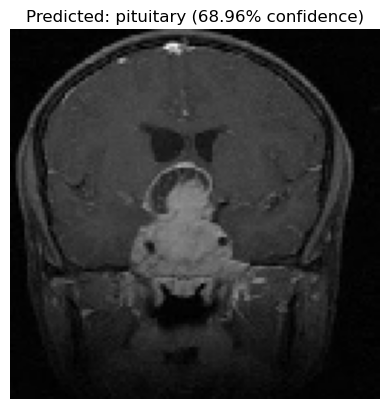


--- Prediction Result ---
Predicted Class: pituitary
Confidence: 68.96%
Raw Probabilities: [[7.8212150e-04 6.8189106e-06 6.8957150e-01 3.0963966e-01]]


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Define class names (same order as training folders) ---
# Make sure these match your folder names exactly in DATA_DIR_TRAIN
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# --- Path of the image to test ---
test_image_path = "3.jpg"  # <- change this path

# --- Step 1: Load and preprocess the image ---
img = image.load_img(test_image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize just like training data

# --- Step 2: Predict ---
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[predicted_class_index]
confidence = np.max(predictions)

# --- Step 3: Display results ---
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}% confidence)")
plt.axis('off')
plt.show()

print("\n--- Prediction Result ---")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Raw Probabilities: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


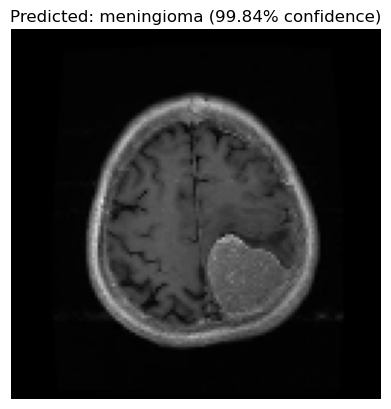


--- Prediction Result ---
Predicted Class: meningioma
Confidence: 99.84%
Raw Probabilities: [[1.5626253e-03 9.9843687e-01 3.3826464e-07 1.1766462e-07]]


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Define class names (same order as training folders) ---
# Make sure these match your folder names exactly in DATA_DIR_TRAIN
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# --- Path of the image to test ---
test_image_path = "2.jpg"  # <- change this path

# --- Step 1: Load and preprocess the image ---
img = image.load_img(test_image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize just like training data

# --- Step 2: Predict ---
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[predicted_class_index]
confidence = np.max(predictions)

# --- Step 3: Display results ---
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}% confidence)")
plt.axis('off')
plt.show()

print("\n--- Prediction Result ---")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Raw Probabilities: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


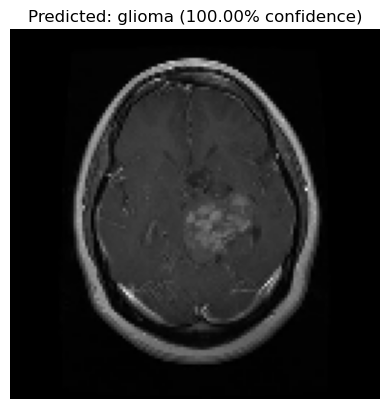


--- Prediction Result ---
Predicted Class: glioma
Confidence: 100.00%
Raw Probabilities: [[9.9998164e-01 5.7833603e-07 2.1335418e-06 1.5577838e-05]]


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Define class names (same order as training folders) ---
# Make sure these match your folder names exactly in DATA_DIR_TRAIN
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# --- Path of the image to test ---
test_image_path = "1.jpg"  # <- change this path

# --- Step 1: Load and preprocess the image ---
img = image.load_img(test_image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize just like training data

# --- Step 2: Predict ---
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[predicted_class_index]
confidence = np.max(predictions)

# --- Step 3: Display results ---
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}% confidence)")
plt.axis('off')
plt.show()

print("\n--- Prediction Result ---")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Raw Probabilities: {predictions}")